In [13]:
import cu_rsc as cr
cr.setup_tables()
import RSC_sim
import numpy as np
import cupy as cp
import cupyx
import matplotlib.pyplot as plt
from tqdm import tqdm
M_dev = cr.load_m_table_device()        # upload to GPU
res   = cr.resources_from_config(M_dev)

### Generation 008 performance

In [67]:
gen_008 = np.load("../op_amp_time/omega_time_ga_runs/OmegaTimeGA_20260204_154626/gen_008/best_sequence.npy")
print(np.unique(gen_008, axis=0))

[[ 0.00000000e+00 -3.00000000e+00  1.73895436e+04  7.51027161e-05]
 [ 0.00000000e+00 -2.00000000e+00  1.79695782e+04  6.24385785e-05]
 [ 0.00000000e+00 -1.00000000e+00  7.91584780e+03  1.27340723e-04]
 [ 1.00000000e+00 -3.00000000e+00  1.30535321e+04  7.76795354e-05]
 [ 1.00000000e+00 -2.00000000e+00  1.22559573e+04  9.08592442e-05]
 [ 1.00000000e+00 -1.00000000e+00  3.84749716e+03  1.34979843e-04]
 [ 2.00000000e+00 -1.00000000e+01  1.25355856e+04  3.39803027e-05]
 [ 2.00000000e+00 -9.00000000e+00  8.39977859e+03  4.63338547e-05]
 [ 2.00000000e+00 -8.00000000e+00  1.52745029e+04  4.71811988e-05]
 [ 2.00000000e+00 -7.00000000e+00  7.19223554e+03  2.95005248e-05]
 [ 2.00000000e+00 -6.00000000e+00  6.53491886e+03  3.25268923e-05]
 [ 2.00000000e+00 -5.00000000e+00  7.34431742e+03  6.36227808e-05]
 [ 2.00000000e+00 -4.00000000e+00  1.91561014e+03  9.99958463e-05]
 [ 2.00000000e+00 -3.00000000e+00  1.87314116e+03  5.25615613e-05]
 [ 2.00000000e+00 -2.00000000e+00  1.76842829e+03  4.10671951e

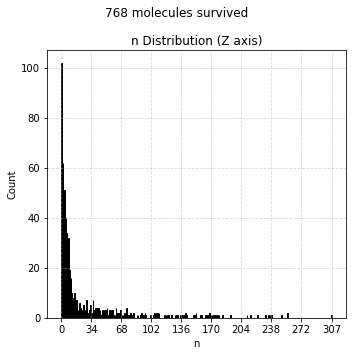

{'survival_rate_mean': array(0.768),
 'survival_rate_sem': array(0.0004169),
 'mot_mean': array([ 0.61458333,  1.53645833, 25.07552083]),
 'mot_sem': array([0.00434177, 0.00636398, 0.05128385]),
 'ground_state_rate_mean': array(0.0945122),
 'ground_state_rate_sem': array(0.00030506),
 'N': array(1000),
 'B': array(1000)}

In [68]:
temp = [25e-6, 25e-6, 25e-6]
mol_0 = cr.build_thermal_molecules(1000, temp, detuning_sigma=0)
cr.raman_cool_with_pumping(mol_0, gen_008, res)
dist = cr.get_n_distribution_gpu(mol_0, max_bins=10, plot=(False, False, True))
result = cr.bootstrap_stats_from_molecules(mol_0)
result

In [70]:
print("survival rate: ", np.round(result["survival_rate_mean"], 3))
print("N_z bar: ", np.round(result["mot_mean"][2], 3))
print("Ground state rate: ", np.round(result["ground_state_rate_mean"],3))

survival rate:  0.768
N_z bar:  25.076
Ground state rate:  0.095


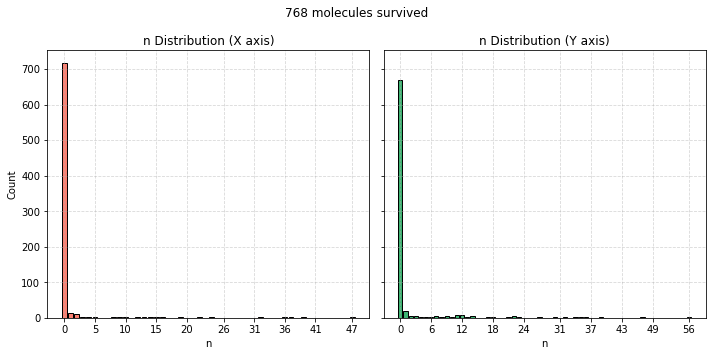

In [69]:
dist = cr.get_n_distribution_gpu(mol_0, max_bins=10, plot=(True, True, False))

In [5]:
zt_freqs = cp.linspace(-60e3, 60e3, 1000)
zt_rabi = 1.01e3
zt_pulse = 500e-6


frequencys, polarizations_opt = cr.raman_sideband_thermometry(
    molecules_dev=mol_0,
    axis=2,
    frequencys=zt_freqs,
    rabi_freq=zt_rabi,
    pulse_time=zt_pulse,
    res=res,
    k_max=2
)

Raman thermometry: 100%|██████████| 1000/1000 [00:16<00:00, 62.42it/s]


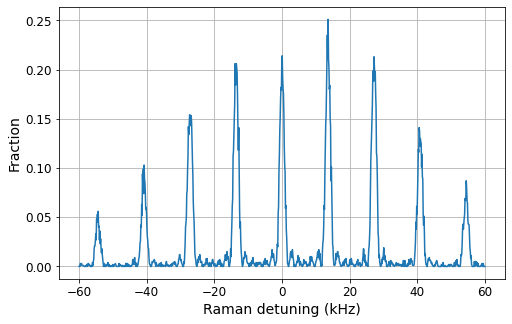

In [6]:
plt.figure(figsize=(8,5))
plt.plot(cp.asnumpy(frequencys*1e-3), cp.asnumpy(polarizations_opt)/1000)
plt.xlabel("Raman detuning (kHz)", fontsize=14)
plt.ylabel("Fraction", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid()

### LZ sweep

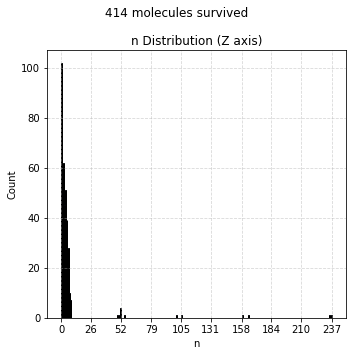

survival rate:  0.414
N_z bar:  5.732
Ground state rate:  0.22


In [107]:
mol = mol_0.copy()
cr.apply_lz_sweep(mol, axis=2, d_n=-5, Omega_lin=10e3, Delta_sweep=5e3, t_sec=10e-3, res=res)
cr.blow_pulse(mol)
dist = cr.get_n_distribution_gpu(mol, max_bins=10, plot=(False, False, True))
result = cr.bootstrap_stats_from_molecules(mol)
print("survival rate: ", np.round(result["survival_rate_mean"], 3))
print("N_z bar: ", np.round(result["mot_mean"][2], 3))
print("Ground state rate: ", np.round(result["ground_state_rate_mean"],3))

In [90]:
import json
payload = {
    "axes": ["x", "y", "z"],
    "counts": [{str(k): int(v) for k, v in d.items()} for d in dist],
}

with open("distributions/XYZ4_LZ5.json", "w") as f:
    json.dump(payload, f, indent=2)

In [91]:
zt_freqs = cp.linspace(-60e3, 60e3, 1000)
zt_rabi = 1.01e3
zt_pulse = 500e-6


frequencys, polarizations_opt = cr.raman_sideband_thermometry(
    molecules_dev=mol,
    axis=2,
    frequencys=zt_freqs,
    rabi_freq=zt_rabi,
    pulse_time=zt_pulse,
    res=res,
    k_max=2
)

Raman thermometry:   0%|          | 0/1000 [00:00<?, ?it/s]

Raman thermometry: 100%|██████████| 1000/1000 [00:15<00:00, 62.98it/s]


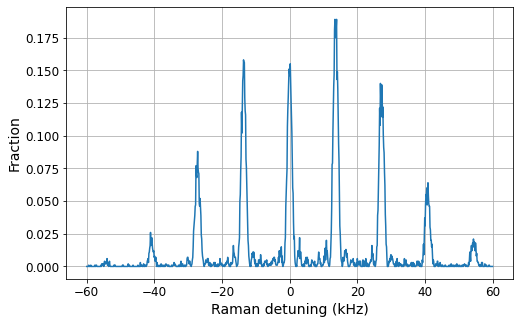

In [92]:
plt.figure(figsize=(8,5))
plt.plot(cp.asnumpy(frequencys*1e-3), cp.asnumpy(polarizations_opt)/1000)
plt.xlabel("Raman detuning (kHz)", fontsize=14)
plt.ylabel("Fraction", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid()

#### Summary

In [55]:
pulse_order = np.linspace(1, 9, 9)
survival_rate = np.array([0.191, 0.214, 0.303, 0.42, 0.531, 0.584, 0.611, 0.649, 0.657])
n_bar = np.array([29.408, 17.523, 15.96, 10.826, 11.03, 11.284, 10.025, 10.752, 13.138])
ground_rate = np.array([0.453, 0.405, 0.286, 0.207, 0.164, 0.149, 0.142, 0.134, 0.129])

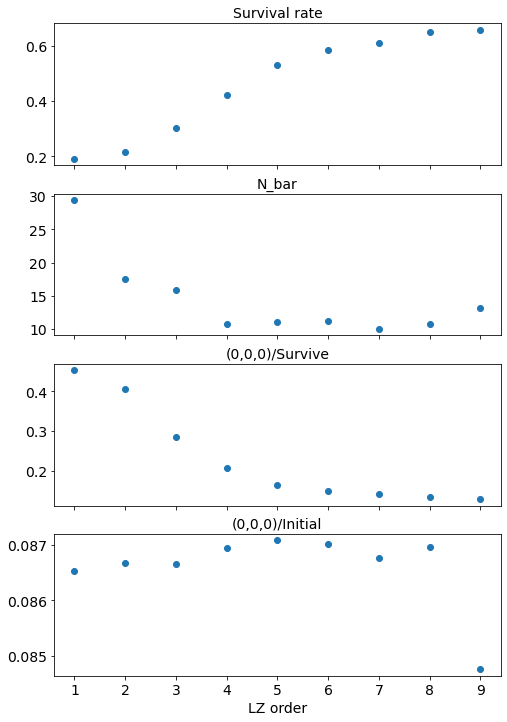

In [64]:
fig, ax = plt.subplots(4, 1, figsize=(8, 12), sharex=True)

ax[0].plot(pulse_order, survival_rate, 'o')
ax[0].set_title("Survival rate", fontsize=14)

ax[1].plot(pulse_order, n_bar, 'o')
ax[1].set_title("N_bar", fontsize=14)

ax[2].plot(pulse_order, ground_rate, 'o')
ax[2].set_title("(0,0,0)/Survive", fontsize=14)

ax[3].plot(pulse_order, survival_rate * ground_rate, 'o')
ax[3].set_title("(0,0,0)/Initial", fontsize=14)
ax[3].set_xlabel("LZ order", fontsize=14)

# Increase tick size for all subplots
for a in ax:
    a.tick_params(axis='both', which='major', labelsize=14)


### Scan LZ parameter

#### $\Omega$ with t=10ms

In [94]:
lz_omegas = np.linspace(1e3, 20e3, 20)
pulse_orders = np.linspace(1, 10, 10)
survivals = np.empty((len(pulse_orders), len(lz_omegas)))
n_bars = np.empty((len(pulse_orders), len(lz_omegas)))
for i, order in enumerate(pulse_orders):
    for j, lz_omega in enumerate(lz_omegas):
        mol = mol_0.copy()
        cr.apply_lz_sweep(mol, axis=2, d_n=-order, Omega_lin=lz_omega, Delta_sweep=5e3, t_sec=10e-3, res=res)
        cr.blow_pulse(mol)
        dist = cr.get_n_distribution_gpu(mol, max_bins=10, plot=(False, False, False))
        result = cr.bootstrap_stats_from_molecules(mol)
        survivals[i, j] = result["survival_rate_mean"].get()
        n_bars[i, j] = result["mot_mean"].get()[2]
survivals = np.array(survivals)
n_bars = np.array(n_bars)

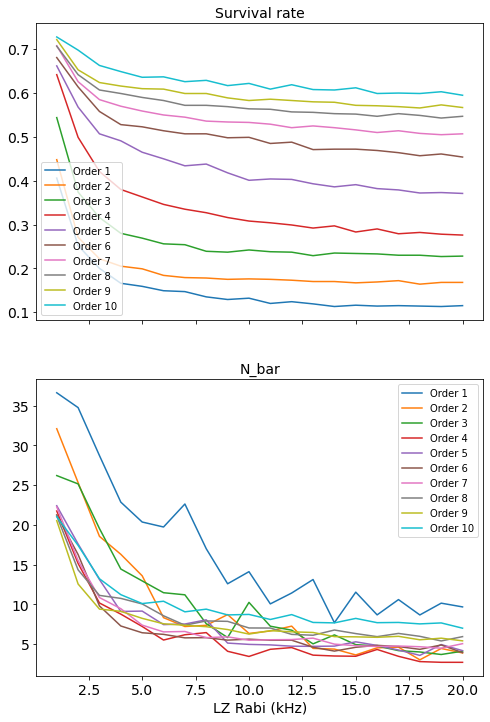

In [105]:
fig, ax = plt.subplots(2, 1, figsize=(8, 12), sharex=True)

for i in range(len(pulse_orders)):
    ax[0].plot(lz_omegas/1e3, survivals[i], label=f"Order {pulse_orders[i]:.0f}")
    ax[1].plot(lz_omegas/1e3, n_bars[i], label=f"Order {pulse_orders[i]:.0f}")
ax[0].set_title("Survival rate", fontsize=14)
ax[0].legend()
ax[1].legend()
ax[1].set_title("N_bar", fontsize=14)

ax[1].set_xlabel("LZ Rabi (kHz)", fontsize=14)

# Increase tick size for all subplots
for a in ax:
    a.tick_params(axis='both', which='major', labelsize=14)
